In [1]:
import srt
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import datetime
import numpy as np
from scipy.interpolate import spline

#plt.xkcd()

In [2]:
# process input data and store features of each in a list of dictionaries
# features: label, subtitles, wpms, start time, end time, length
file_list = []
file_list.append("inputs/Innovating to zero!   Bill Gates.srt")


subtitle_list = []
for index, input in enumerate(file_list):
    current_dict = {}
    with open(input, 'r') as myfile:
#        data = myfile.read().decode("utf-8-sig").encode("utf-8")
        data = myfile.read().decode("utf-8-sig")
    
    subtitle_generator = srt.parse(data)
    subtitles = list(subtitle_generator)
    current_dict['start_time'] = subtitles[0].start
    current_dict['end_time'] = subtitles[-1].end
    current_dict['total_time'] = (current_dict['end_time']-current_dict['start_time']).total_seconds()

    # put contents of Subtitle objects (basically sentences) in pangas
    wpms = []
    wordcounts = []
    lengths = []
    subtitle_contents = [subtitle.content.replace('\n',' ') for subtitle in subtitles]
    subtitle_starts = [subtitle.start for subtitle in subtitles]
    subtitle_ends = [subtitle.end for subtitle in subtitles]

    df = pd.DataFrame({'contents':subtitle_contents,
                       'start':subtitle_starts,
                       'end':subtitle_ends})
    df['wordcount'] = df['contents'].str.split().str.len()
    df['length'] = df.apply(lambda row: (row['end'] - row['start']).total_seconds(), axis=1)
    df['wpm'] = df['wordcount']/df['length']*60
    current_dict['subtitles'] = df
    subtitle_list.append(current_dict)
    

/Users/lantonel/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/lantonel/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.
/Users/lantonel/anaconda/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


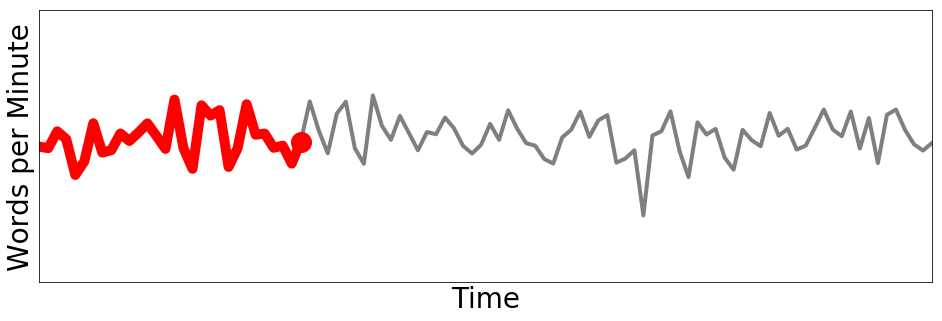

In [3]:
# make smooothed time-series plots of WPM rate for various inputs

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 16
fig_size[1] = 5
plt.rcParams["figure.figsize"] = fig_size
plt.rcParams.update({'font.size': 28})

for entry in subtitle_list:
    #filter out applause and laughter
    df = entry['subtitles']
    df = df[~df['contents'].str.contains('Applause') & ~df['contents'].str.contains('Laughter')]

    df['start_fraction'] = df.apply(lambda row: ((row['start'] - entry['start_time']).total_seconds())/entry['total_time'], axis=1)
#    df['start_fraction'] = df.apply(lambda row: ((row['start'] - entry['start_time']).total_seconds()), axis=1)
    x = df['start_fraction'].tolist()
    y = df['wpm'].tolist()
    x_new = np.linspace(x[0],x[-1],100)
    y_new = spline(x,y,x_new)
    x_reduced = x_new[:int(0.3*len(x_new))]
    y_reduced = y_new[:int(0.3*len(x_new))]
    #    plt.plot(x,y)
    plt.plot(x_new,y_new, color='k',linewidth=4,alpha=0.5)
    plt.plot(x_reduced,y_reduced, color='r',linewidth=10)
    plt.plot(x_reduced[-1],y_reduced[-1],color='r',marker='o',markersize=20)
    
axes = plt.gca()
leg = plt.legend()
axes.set_ylabel("Words per Minute")
axes.set_xlabel("Time")
axes.set_xlim(x[0],x[-1])
axes.set_ylim(-150,450)
axes.get_xaxis().set_ticks([])
axes.get_yaxis().set_ticks([])
plt.savefig('demo.pdf', transparent=True,bbox_inches='tight')
plt.show()


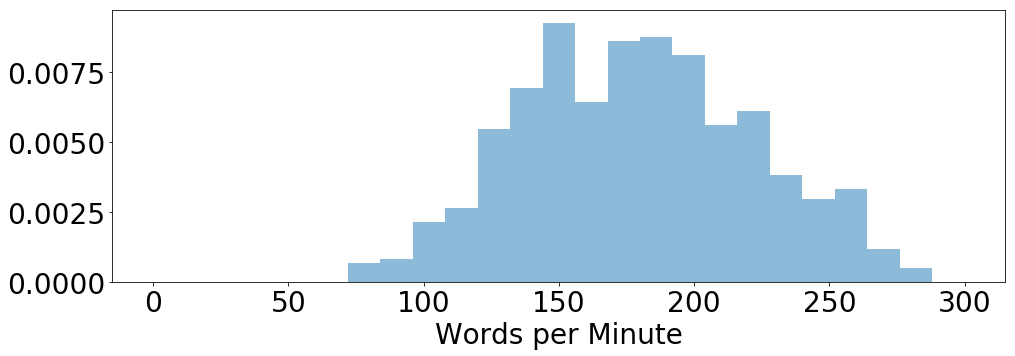

In [4]:
hist_entries = []
labels = []
for entry in subtitle_list:
    df = entry['subtitles']
    df = df[~df['contents'].str.contains('Applause') & ~df['contents'].str.contains('Laughter')]
    hist_entries.append(df['wpm'].tolist())
 
    
plot = plt.hist(hist_entries, 
                25, 
                range=[0, 300], 
                histtype='stepfilled', 
                stacked=False,
                alpha=0.5,
                normed=True,
                edgecolor = "none",
                linewidth=0,
                label=labels)


leg = plt.legend()
axes = plt.gca()
axes.set_xlabel("Words per Minute")
plt.show()